# imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geojson
import xgboost as xgb
import warnings
import os
warnings.filterwarnings('ignore')

from mpl_toolkits.basemap import Basemap
from matplotlib import cm
from descartes import PolygonPatch
from haversine import haversine

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import MiniBatchKMeans


In [ ]:
root_dir = os.getcwd()
train = pd.read_csv(os.path.join(root_dir, 'split/train.csv'))
test = pd.read_csv(os.path.join(root_dir, 'split/val.csv'))
train.head()


id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


In [10]:
# prepare
# if 'id' in train.columns:
#     train.drop(columns=['id'], inplace=True)
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['dayofweek'] = train.pickup_datetime.dt.dayofweek
train['month'] = train.pickup_datetime.dt.month
train['hour'] = train.pickup_datetime.dt.hour
train['dayofyear'] = train.pickup_datetime.dt.dayofyear
train['log_trip_duration'] = np.log1p(train.trip_duration)

numeric_features = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
categorical_features = ['dayofweek', 'month', 'hour', 'dayofyear', 'passenger_count']
train_features = categorical_features + numeric_features

train_numeric = train[numeric_features]
train_categorical = train[categorical_features]

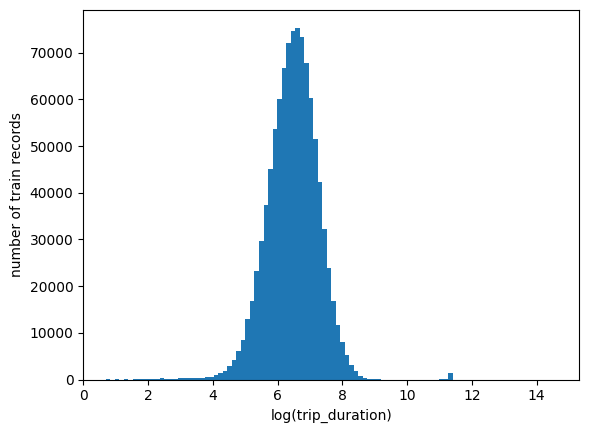

In [11]:
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

Some points are far away from the boundaries of NYC. Let's limit the scope for visualization purposes, at least.

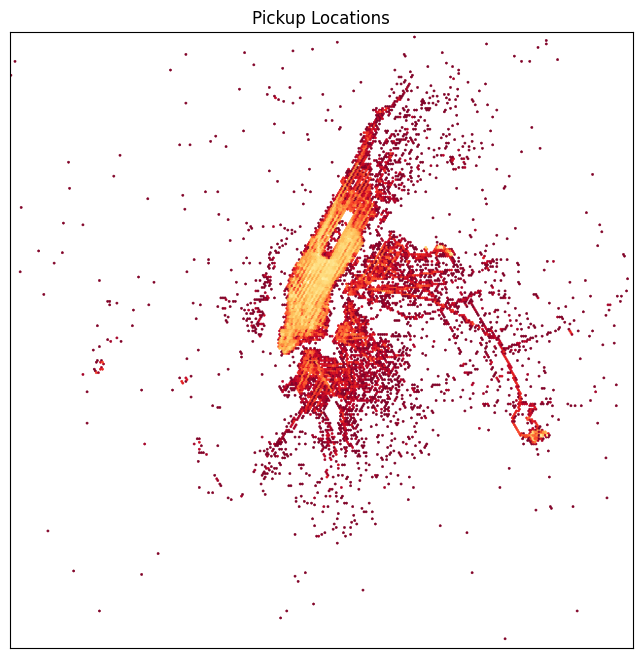

In [12]:
west, south, east, north = -74.26, 40.50, -73.70, 40.92
train = train[(train['pickup_longitude'] > west) & (train['pickup_longitude'] < east)]
train = train[(train['pickup_latitude'] > south) & (train['pickup_latitude'] < north)]

fig = plt.figure(figsize=(14,8))

m = Basemap(projection='merc', llcrnrlat=south, urcrnrlat=north,
            llcrnrlon=west, urcrnrlon=east, lat_ts=south, resolution='c')
x, y = m(train['pickup_longitude'].values, train['pickup_latitude'].values)
m.hexbin(x, y, gridsize=300, bins='log', cmap=cm.YlOrRd_r, lw=0.4)

plt.title('Pickup Locations')
plt.show()

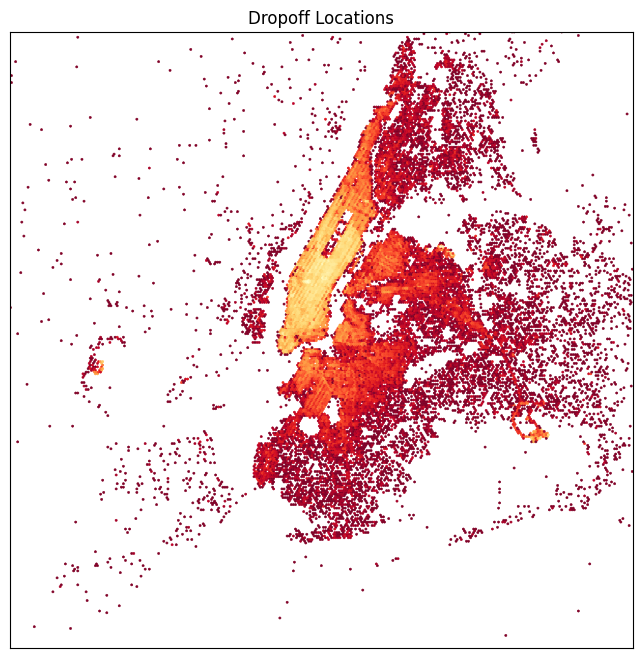

In [13]:
west, south, east, north = -74.26, 40.50, -73.70, 40.92
train = train[(train['dropoff_longitude'] > west) & (train['dropoff_longitude'] < east)]
train = train[(train['dropoff_latitude'] > south) & (train['dropoff_latitude'] < north)]

fig = plt.figure(figsize=(14,8))

m = Basemap(projection='merc', llcrnrlat=south, urcrnrlat=north,
            llcrnrlon=west, urcrnrlon=east, lat_ts=south, resolution='c')
x, y = m(train['dropoff_longitude'].values, train['dropoff_latitude'].values)
m.hexbin(x, y, gridsize=300, bins='log', cmap=cm.YlOrRd_r, lw=0.4)

plt.title('Dropoff Locations')
plt.show()

Maximum number of passengers on a trip :  7
Minimum number of passengers on a trip :  0
Average number of passengers on a trip :  1.6654712407140126


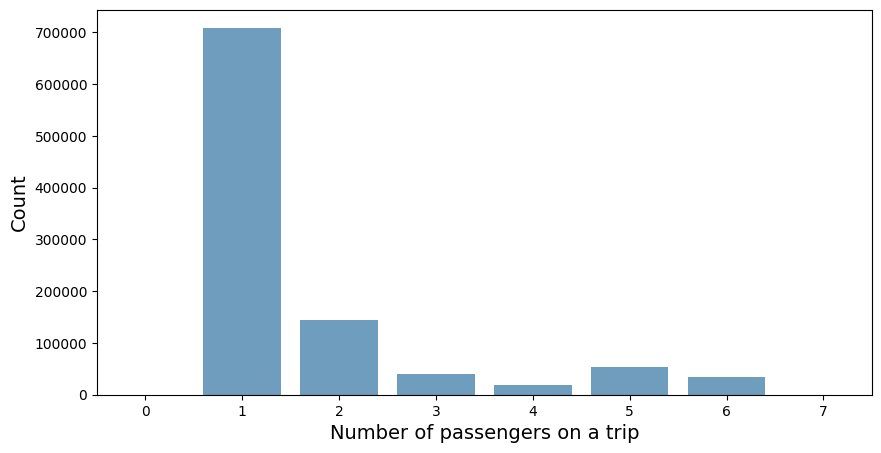

In [14]:
pass_count = train['passenger_count']
print("Maximum number of passengers on a trip : ", np.max(pass_count.values))
print("Minimum number of passengers on a trip : ", np.min(pass_count.values))
print("Average number of passengers on a trip : ", np.mean(pass_count.values))

f = plt.figure(figsize=(10,5))
pass_count = train['passenger_count'].value_counts()
sns.barplot(x=pass_count.index, y=pass_count.values, alpha=0.7)
plt.xlabel('Number of passengers on a trip', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

Clustering and distance with haversine

In [15]:
coords = np.vstack((train[['pickup_latitude',  'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    train[['pickup_latitude',  'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords)

train['pickup_cluster']  = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train['dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])

train['haversine_distance'] = train.apply(lambda x: haversine((x['pickup_latitude'],  x['pickup_longitude']), 
                                                            (x['dropoff_latitude'], x['dropoff_longitude'])), axis=1)

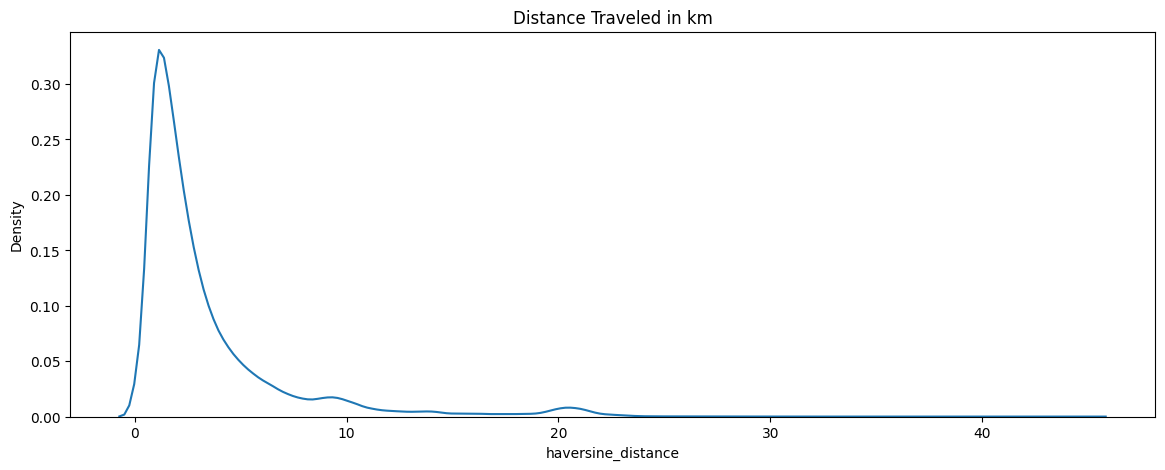

In [16]:
plt.figure(figsize=(14, 5))
plt.title('Distance Traveled in km')
sns.distplot(train['haversine_distance'], hist=False)
plt.show()

Unlike flying directly (which is what Haversine distance simulates), taxis must follow city streets, which are often laid out in a grid. So more realistic for taxis with Manhattan distance

In [ ]:
train["manhattan_distance"] = (
np.abs(train["dropoff_longitude"] - train["pickup_longitude"]) +
np.abs(train["dropoff_latitude"] - train["pickup_latitude"])
)

visualize pickups

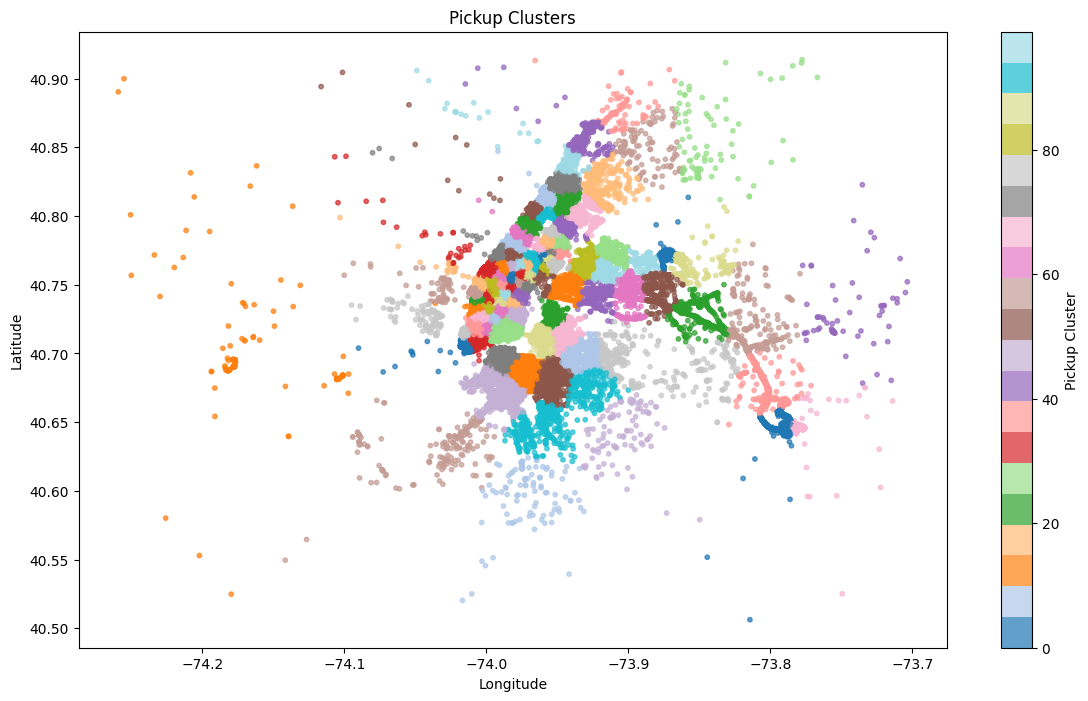

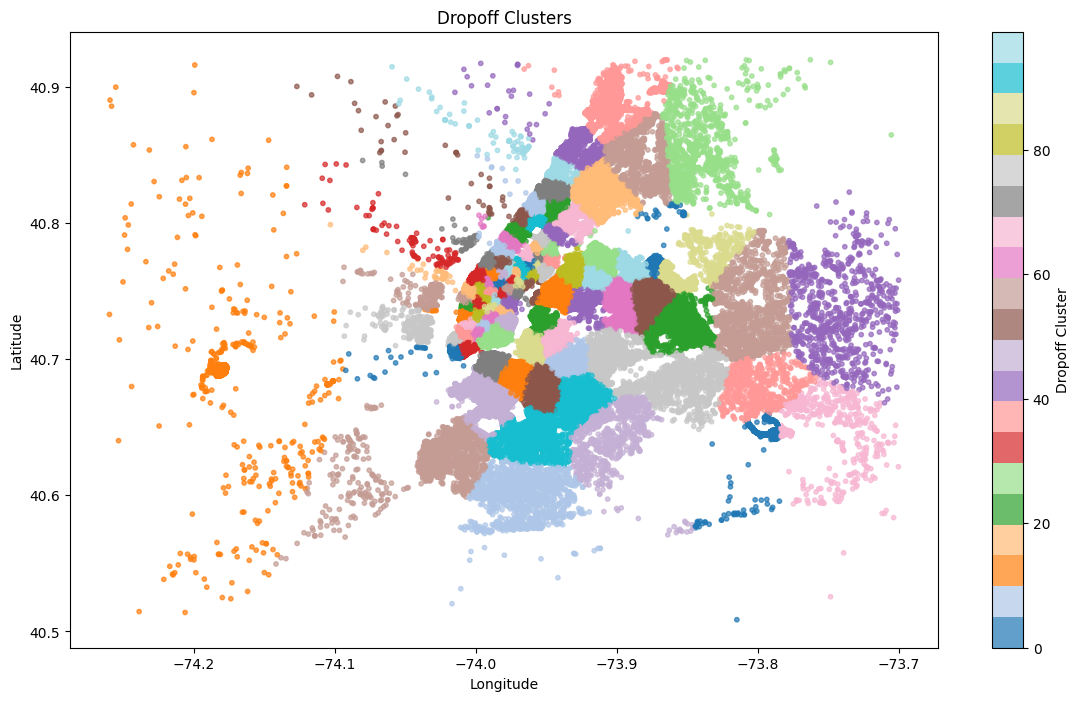

In [29]:
# Visualize pickup clusters
plt.figure(figsize=(14, 8))
plt.scatter(train['pickup_longitude'], train['pickup_latitude'], c=train['pickup_cluster'], cmap='tab20', s=10, alpha=0.7)
plt.colorbar(label='Pickup Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Pickup Clusters')
plt.show()

# Visualize dropoff clusters
plt.figure(figsize=(14, 8))
plt.scatter(train['dropoff_longitude'], train['dropoff_latitude'], c=train['dropoff_cluster'], cmap='tab20', s=10, alpha=0.7)
plt.colorbar(label='Dropoff Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Dropoff Clusters')
plt.show()

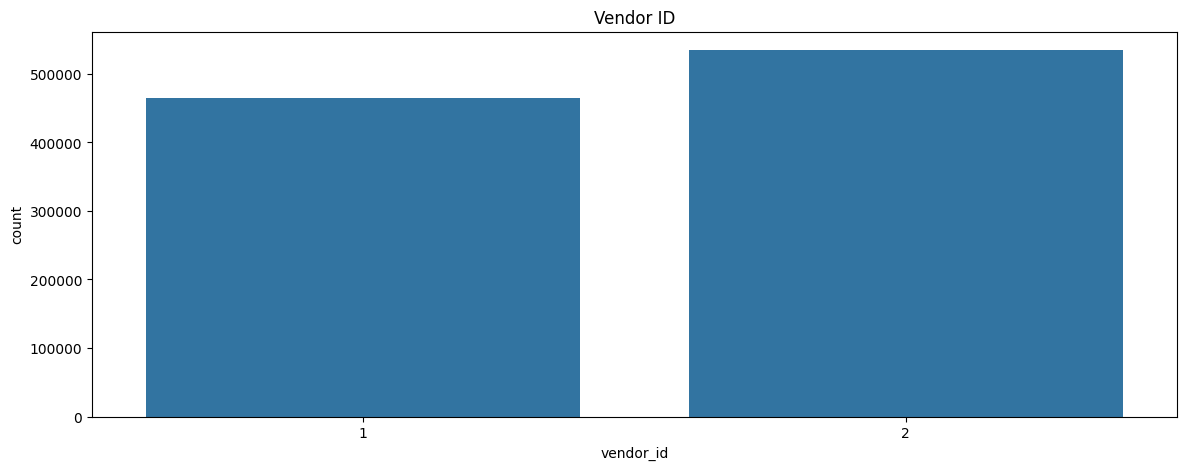

In [6]:
plt.figure(figsize=(14, 5))
plt.title('Vendor ID')
sns.countplot(x='vendor_id', data=train)
plt.show()

vendor_id=2 performed more trips than vendor_id=1

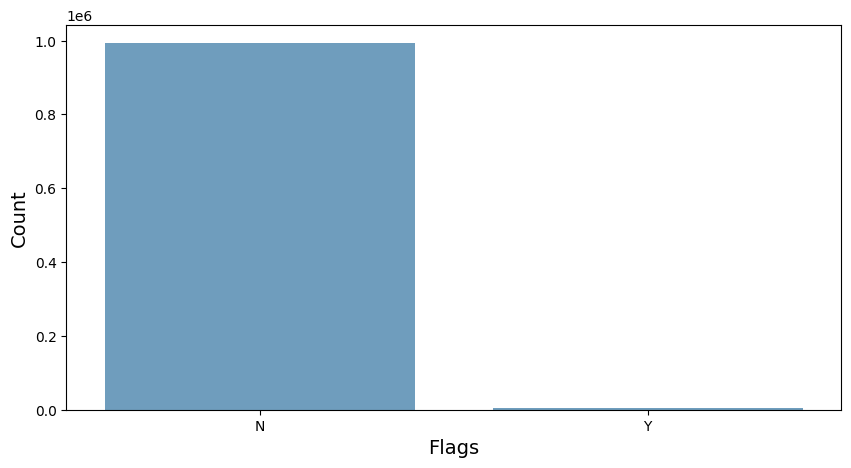

In [18]:
# Let's move to the store_and_fwd_flag column
flags = train['store_and_fwd_flag'].value_counts()

f = plt.figure(figsize=(10,5))
sns.barplot(x=flags.index, y=flags.values, alpha=0.7)
plt.xlabel('Flags', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

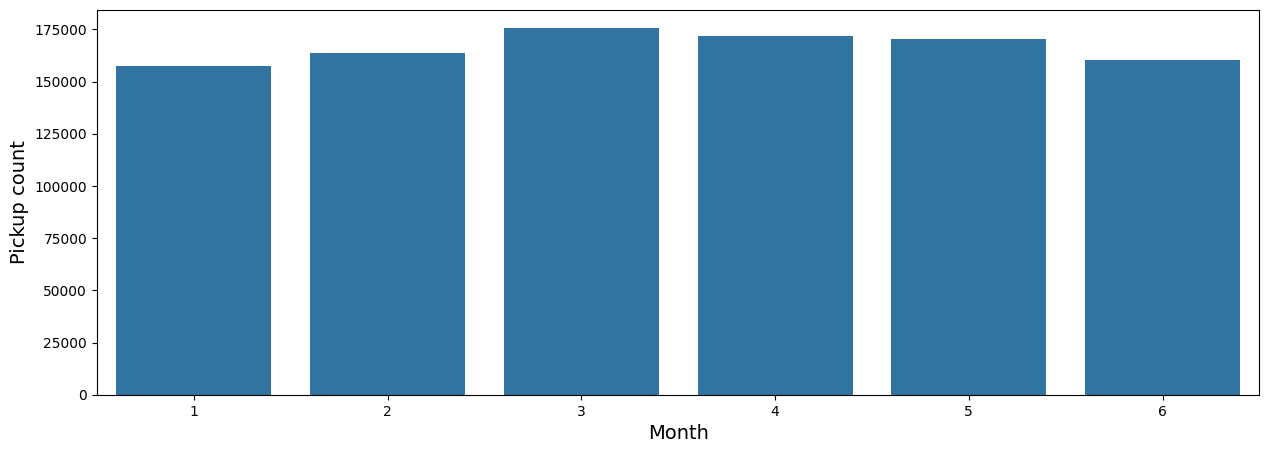

In [19]:
f = plt.figure(figsize=(15,5))
sns.countplot(x='month', data=train)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.show()

there is no major festive season around these months.

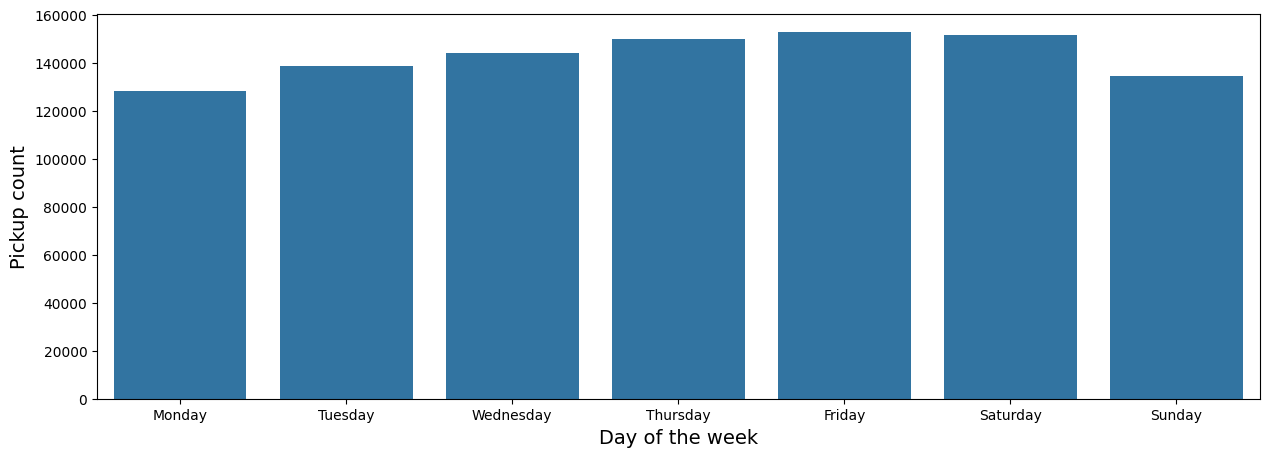

In [20]:
f = plt.figure(figsize=(15,5))
days = [i for i in range(7)]
sns.countplot(x='dayofweek', data=train)
plt.xlabel('Day of the week', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.xticks(days, ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
plt.show()

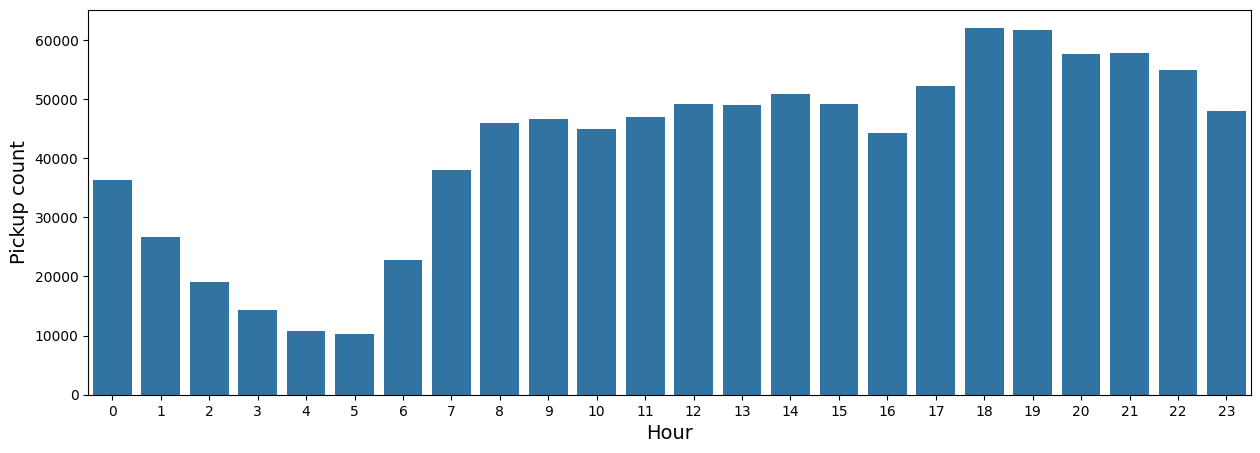

In [21]:
f = plt.figure(figsize=(15,5))
sns.countplot(x='hour', data=train)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.show()

the number of pickups gradually decreases after mid-night. The highest number of pickups are around 6pm and 7pm in the evening which makes sense as many people are on their way to home from office.

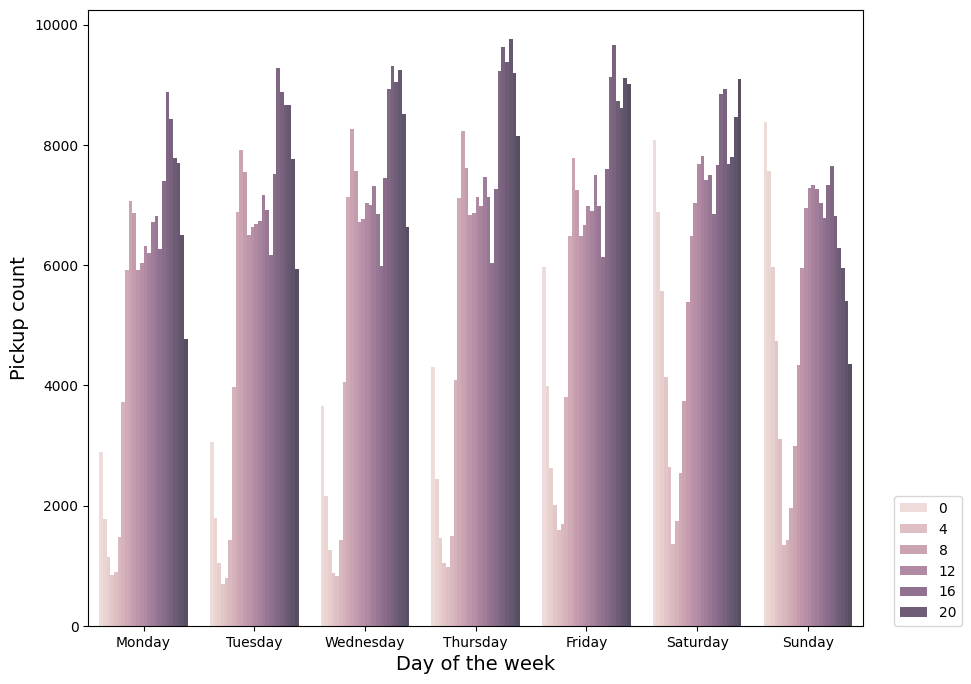

In [22]:
f = plt.figure(figsize=(10,8))
days = [i for i in range(7)]
sns.countplot(x='dayofweek', data=train, hue='hour', alpha=0.8)
plt.xlabel('Day of the week', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.xticks(days, ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
plt.legend(loc=(1.04,0))
plt.show()

the peaks at mid-night on Saturday and Sunday? This should be fine because most of the people are doing parties on weekends.

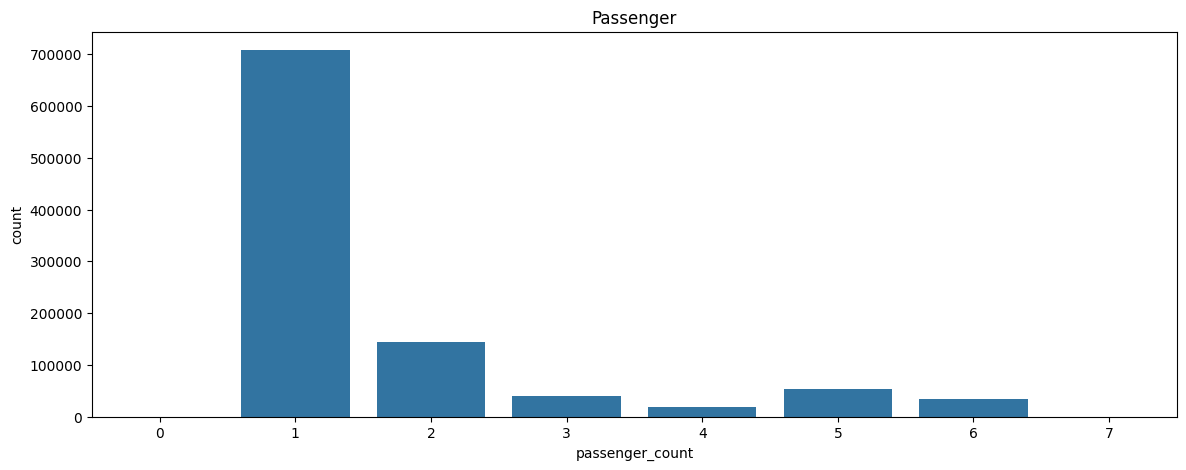

In [23]:
plt.figure(figsize=(14, 5))
plt.title('Passenger')
sns.countplot(x='passenger_count', data=train)
plt.show()

Most passengers travel alone.

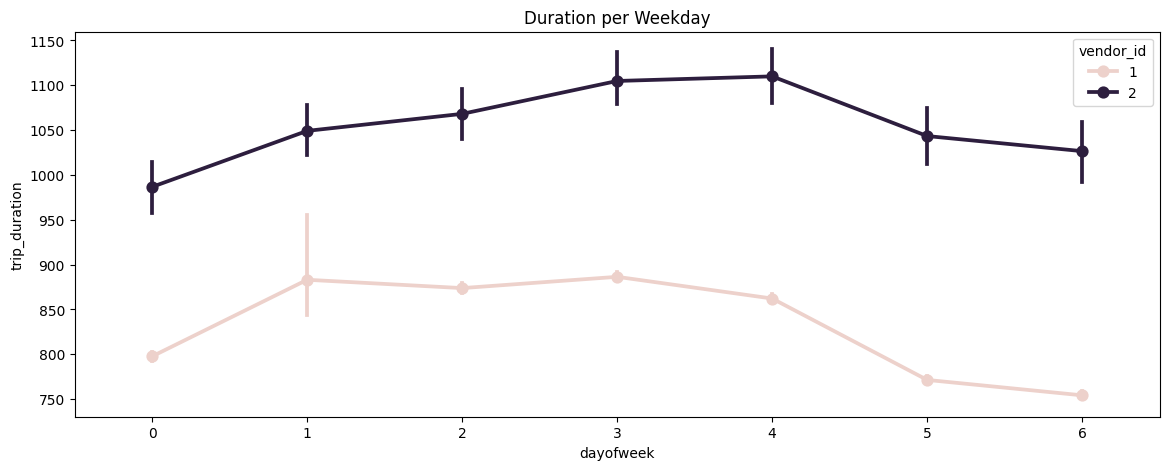

In [24]:
plt.figure(figsize=(14, 5))
plt.title('Duration per Weekday')
sns.pointplot(x='dayofweek', y='trip_duration', hue='vendor_id', data=train)
plt.show()

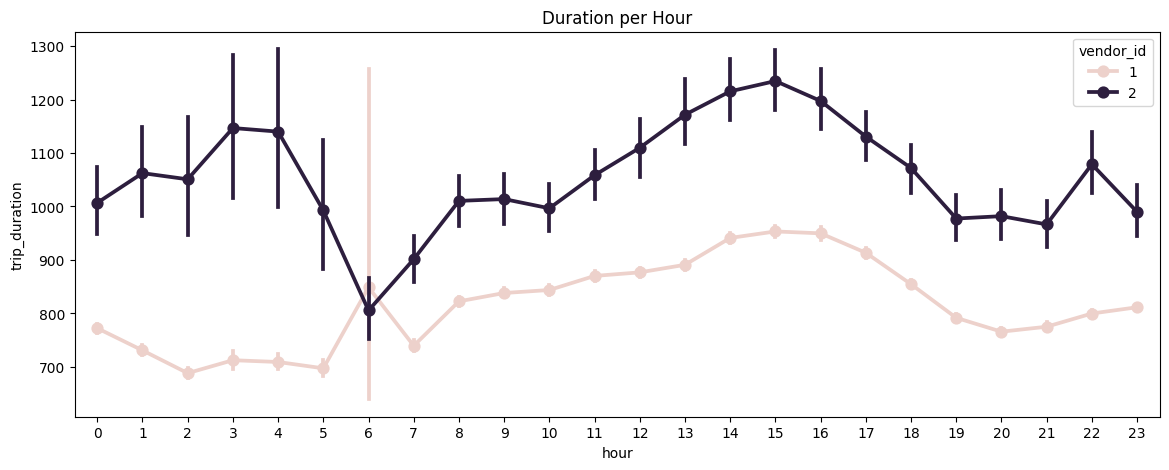

In [25]:
plt.figure(figsize=(14, 5))
plt.title('Duration per Hour')
sns.pointplot(x='hour', y='trip_duration', hue='vendor_id', data=train)
plt.show()

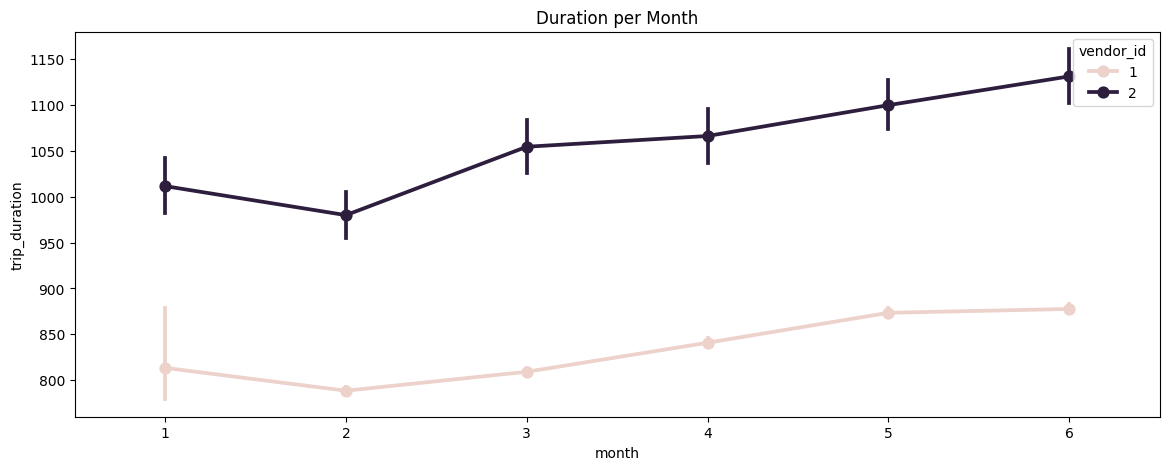

In [26]:
plt.figure(figsize=(14, 5))
plt.title('Duration per Month')
sns.pointplot(x='month', y='trip_duration', hue='vendor_id', data=train)
plt.show()

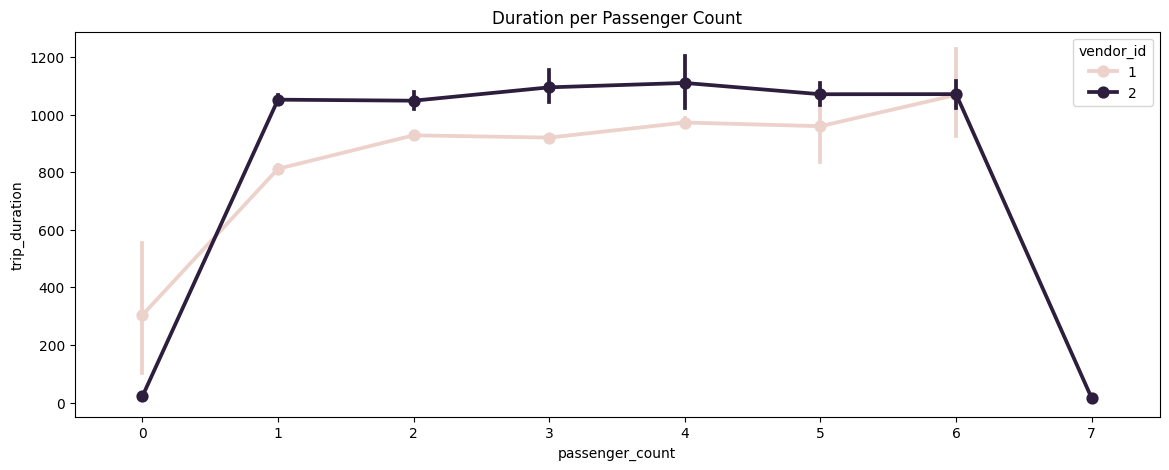

In [27]:
plt.figure(figsize=(14, 5))
plt.title('Duration per Passenger Count')
sns.pointplot(x='passenger_count', y='trip_duration', hue='vendor_id', data=train)
plt.show()

vendor_id=2, besides of taking more rides, also presents longer average trip duration in any weekdays. We can see that both vendors present a similar trip duration during 6am. However, in this case, vendor_id=1 shows higher variability in the average trip duration.

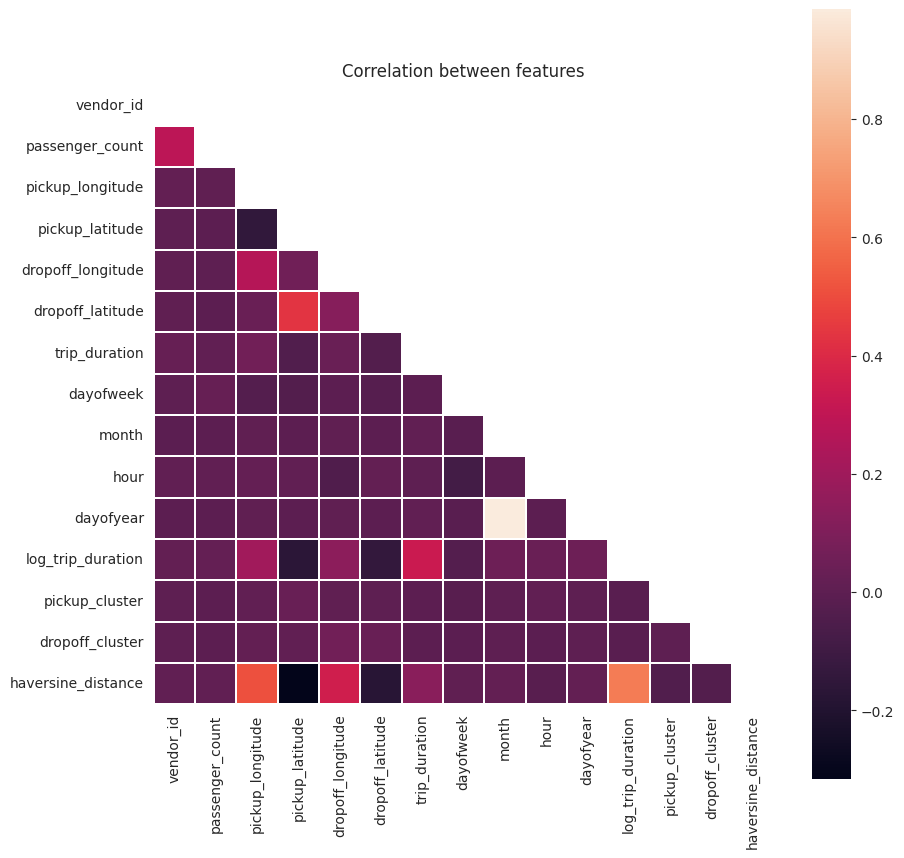

In [28]:
corr = train.select_dtypes(include=[np.number]).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 10))
with sns.axes_style('white'):
    sns.heatmap(corr, mask=mask, linewidths=0.01, square=True, linecolor='white')
plt.xticks(rotation=90)
plt.title('Correlation between features')
plt.show()